# Generating dummy data to mimic a given dataset

### Organization
- The first code cell will generate toy data for a given input dataset, for each primary ID in ```mcip```, using libraries.
- The second code cell is my own code from pretty much scratch that makes toy data. This cell is for my own education.
- The third code cell has been used to check my work.

### General method used
1. Map each parameter in the data to a standard normal distribution by using a quantile transform.
2. Compute the covariance matrix of all of the normalized parameters.
3. Generate multivariate Gaussian samples with a mean of zero and covariance found previously.
4. Inverse quantile transform the generated samples to mimic the input data.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
import scipy as sp

df = pd.read_csv('betterTALEdata/gw_mc_all.data-combined(core_correction).csv')

params = ["xcore","ycore","th","phi","rp","psi","en","xf","xm","dxm","c2t","c2p","xl","sz","fscin","fckov","fscat","mir_id","mir_nmir","mir_ngtube"]

outputdata = []
for i in [1.0, 2.0, 3.0, 4.0, 5.0]:

    
    dfi = df[df['mcip'] == i]
    size = len(dfi)
    
    print('Generating data for primary ID: ', i, ' of size: ', size)

    X = dfi[params].values.T

    #There are going to be a lot of .T s (matrix transposes) going forward. The issue is that np.cov wants
    #the rows to be samples of a single parameter, and each column to be one sample vector, while sklearn
    #wants it the other way.
    qt = QuantileTransformer(n_quantiles=100, output_distribution='normal')
    
    qt.fit(X.T)
    
    normalizedX = qt.transform(X.T).T
    
    covariance = np.cov(normalizedX)
    
    rng = np.random.default_rng() #could specify a random seed if needed
    N = rng.multivariate_normal(np.zeros(len(covariance)), covariance, size=size)
    
    toyX = qt.inverse_transform(N)

    for row in toyX:
        outputdata.append(row.tolist() + [i])
    
outdf = pd.DataFrame(columns=params+['mcip'], data=outputdata)

outdf.to_csv('toy_data.csv', index=False)

Generating data for primary ID:  1.0  of size:  182070
Generating data for primary ID:  2.0  of size:  133768
Generating data for primary ID:  3.0  of size:  99953
Generating data for primary ID:  4.0  of size:  175929
Generating data for primary ID:  5.0  of size:  161818


### From scratch (incomplete)
- So far I have my own quantile transform and inverse quantile transform, which only maps within 3-sigma.
- There is also a Cholesky factorization function, which will be needed later.
- I still need to sample from a Gaussian distribution, most likely using a Box-Muller transform. Then I could generate a bunch of independent Gaussian samples, and use a Cholesky factor of the covariance matrix to generate a multivariate distribution athat has the correct covariances (hopefully)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
import scipy as sp

class quantiletransform:
    """My own quantile transform"""
   
    def __init__(self, bins):
        self.bins = bins
       
        #flag for whether or not the transform has been fit to data yet.
        self.fitflag = False

    def fit(self, X):
        counts, self.nodes = np.histogram(X, bins=self.bins)

        PMFtable = counts/len(X)
        CMFtable = 0.994*np.array([np.sum(PMFtable[0:j+1]) for j in range(len(PMFtable))])

        binincrement = nodes[1] - nodes[0]

        values = [0.0]
        values.extend(CMFtable)
        self.values = np.array(values) + 0.003

        self.slopes = np.append((self.values[1:] - self.values[:-1])/binincrement, 0)

        self.fitflag = True
        print('fit done')
        return

   
    def CDF(self, x):
        if not self.fitflag:
            print('quantiletransform has not been fit to data yet.'); return
           
        if min(x) < self.nodes[0] or max(x) > self.nodes[-1]:
            print('Found a value ouside of interpolation range: ', self.nodes[0], self.nodes[-1]); return

        indices = np.searchsorted(self.nodes, x, side='right') - 1
        deltax = x - self.nodes[indices]
        return self.values[indices] + deltax*self.slopes[indices]
   
    def inverseCDF(self, p):
        if not self.fitflag:
            print('quantiletransform has not been fit to data yet.'); return
           
        if min(p) < self.values[0] or max(p) > self.values[-1]:
            print('Found a value ouside of interpolation range: ', self.values[0], self.values[-1]); return
           
        indices = np.searchsorted(self.values, p, side='right') - 1
        deltap = p - self.values[indices]
        inverseslopes = [1/self.slopes[i] if self.slopes[i] != 0 else 0 for i in indices]
        return self.nodes[indices] + deltap*inverseslopes
   
    def transform(self, X):
        p = self.CDF(X)
        return sp.stats.norm.ppf(p)

    def inversetransform(self, N):
        if min(N) <= -3 or max(N) >= 3:
            print('Found a point outside of 3 sigma.'); return
           
        p = sp.stats.norm.cdf(N)
        return self.inverseCDF(p)

#Cholesky factorization
def cholesky(A):
    #checks
    if (A != A.T).any():
        print('Matrix is not symmetric')
        return
        
    if np.min(np.linalg.eig(A)[0]) < 0:
        print('Matrix is not positive semi-definite')
        return

    n = len(A)
    L = np.zeros((n, n))
    for i in range(n):
        #non-diagonal elements
        for j in range(i):
            L[i,j] = (A[i,j] - L[i, 0:j].dot(L[j, 0:j]))/L[j,j]
        #diagonal elements
        L[i,i] = np.sqrt(A[i,i] - L[i, 0:i].dot(L[i, 0:i]))
   
    #prints maximum error of LL^T and A
    #print(np.max(np.abs(L @ (L.T) - A)))
   
    return L

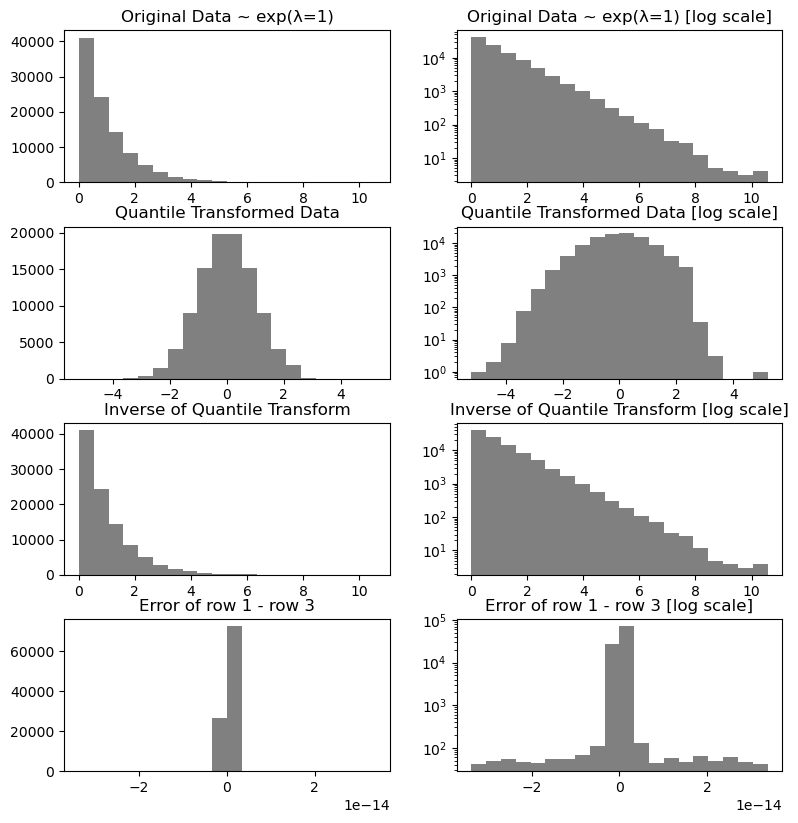

In [10]:
X = np.random.exponential(1.0, size=100000)[:, np.newaxis]

qt = QuantileTransformer(n_quantiles=100, output_distribution='normal', subsample=None)

qt.fit(X)

Y = qt.transform(X)

fig, ax = plt.subplots(4, 2, figsize = (8, 8))
plt.tight_layout()

ax[0, 0].set_title('Original Data ~ exp(λ=1)')
ax[0, 0].hist(X, 20, color='gray')
ax[0, 1].set_title('Original Data ~ exp(λ=1) [log scale]')
ax[0, 1].hist(X, 20, color='gray', log=True)

ax[1, 0].set_title('Quantile Transformed Data')
ax[1, 0].hist(Y, 20, color='gray')
ax[1, 1].set_title('Quantile Transformed Data [log scale]')
ax[1, 1].hist(Y, 20, color='gray', log=True)

Z = qt.inverse_transform(Y)

ax[2, 0].set_title('Inverse of Quantile Transform')
ax[2, 0].hist(Z, 20, color='gray')
ax[2, 1].set_title('Inverse of Quantile Transform [log scale]')
ax[2, 1].hist(Z, 20, color='gray', log=True)

error = X - Z

ax[3, 0].set_title('Error of row 1 - row 3')
ax[3, 0].hist(error, 20, color='gray')
ax[3, 1].set_title('Error of row 1 - row 3 [log scale]')
ax[3, 1].hist(error, 20, color='gray', log=True)

plt.show()